In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from numpy.random import seed
from tensorflow import set_random_seed
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json
from scipy.special import softmax

Using TensorFlow backend.


In [3]:
main_df = pd.read_csv('data.csv')
main_df.describe()

,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed,month,day,hour,sample_Number
count,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,928491.000000,928491.000000,928491.000000,928491.00000
mean,4.102069e+00,-1.206338e-01,-5.472746e-05,3.371415e+08,1.945795e+03,1.488169e+08,5.367032e+03,9.847591e-01,1.927328e+03,4.983090,16.374244,136214.317192,246.45296
std,2.364827e+00,6.078708e-01,1.212122e-01,5.466868e+08,4.873922e+03,2.711355e+08,3.382194e+03,3.437204e-01,6.559047e+02,3.457797,8.514075,32483.732147,149.29589
min,4.000000e-03,-6.560303e+00,-1.888258e+00,-2.039056e+09,-9.482574e+03,1.936250e+05,-2.013385e+01,-9.143658e-01,0.000000e+00,1.000000,1.000000,81158.000000,0.00000
25%,2.056000e+00,-3.696310e-01,-2.201461e-02,8.626082e+07,-1.908875e+03,2.136702e+07,3.032669e+03,8.384416e-01,1.500000e+03,2.000000,9.000000,111317.000000,116.00000
50%,4.104000e+00,-1.187128e-01,6.456900e-04,1.919407e+08,2.595520e+03,7.259557e+07,4.582979e+03,9.711797e-01,1.800000e+03,4.000000,17.000000,134043.000000,240.00000
75%,6.152000e+00,2.546913e-01,2.380830e-02,5.691639e+08,5.441666e+03,1.602507e+08,5.823731e+03,1.105926e+00,2.280000e+03,8.000000,23.000000,161746.000000,374.00000
max,8.199999e+00,3.856873e+00,2.021531e+00,1.911789e+09,1.792831e+04,1.453671e+09,1.797202e+04,3.567880e+00,3.600000e+03,12.000000,31.000000,223249.000000,518.00000


#OCSVM

In [43]:
#Grabbing the entire dataset
main_df = pd.read_csv('data.csv')
#Dropping columns with unwanted/irrelevant info for the algorithm
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
#Transforming modes into classified data
main_df = handle_non_numeric(main_df)

#Passing our dataframe as our features
X = main_df

#Defining preprocessor for the data
scaler = preprocessing.MinMaxScaler()
#Preprocessing
X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)


#Scaling
X = preprocessing.scale(X)
#Splitting the feature data for training data. First 200.000 rows.
X_train = X[:200000]


#Creating a fitting OneClass SVM
ocsvm = OneClassSVM(nu=0.25, gamma=0.05)
ocsvm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
            max_iter=-1, nu=0.25, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [9]:
df=main_df.copy()
df['anomaly'] = pd.Series(ocsvm.predict(X))
df.to_csv('compiled_df//Labled_df.csv')
df = pd.read_csv('compiled_df//Labled_df.csv', index_col=0)
df.head()

,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed,mode,anomaly
0,0.199603,0.027420,628392628,-920.104980,5298555,2441.235352,0.899543,1379.999756,2,1
1,0.281624,0.002502,628392625,-937.271118,5298565,2453.819092,0.874072,1379.999756,2,1
2,0.349315,-0.018085,628392621,-951.004028,5298575,2476.469727,0.879806,1379.999756,2,1
3,0.444450,-0.054680,628392617,-1019.668579,5298585,2501.637207,0.837500,1379.999756,2,1
4,0.480923,-0.042770,628392613,-1023.101807,5298595,2519.254395,0.905347,1379.999756,2,1


**Visualizing anomalies**

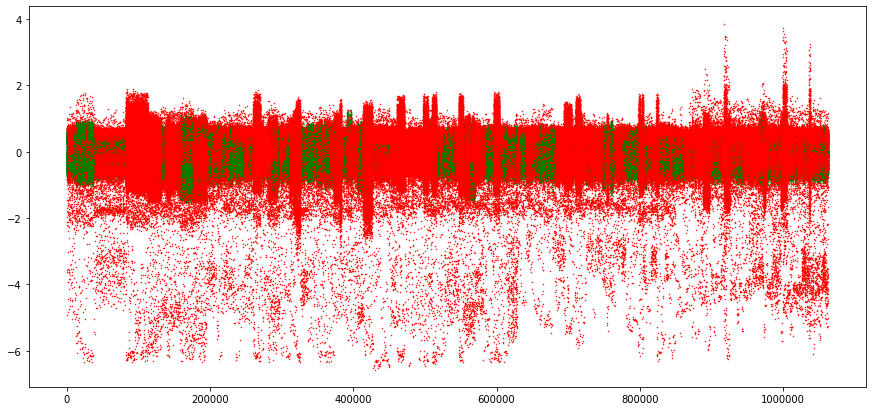

In [47]:
#Getting labled groups
scat_1 = df.groupby('anomaly').get_group(1)
scat_0 = df.groupby('anomaly').get_group(-1)

# Plot size
plt.subplots(figsize=(15,7))

# Plot group 1 -labeled, color green, point size 1
plt.plot(scat_1.index,scat_1['pCut::Motor_Torque'], 'g.', markersize=1)

# Plot group -1 -labeled, color red, point size 1
plt.plot(scat_0.index, scat_0['pCut::Motor_Torque'],'r.', markersize=1)


**Visualizing scores for the whole dataset**

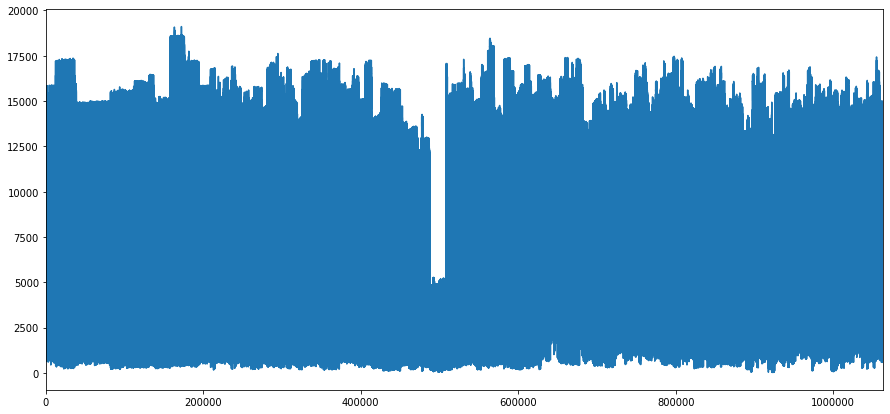

In [48]:
#Creating a dataframe for the score of each data sample
score = pd.DataFrame()
#Returning scores for the dataset
score['score'] = ocsvm.score_samples(X)

#Plot size
plt.subplots(figsize=(15,7))
#Plotting
score['score'].plot()
#Saving score dataframe
score.to_csv('compiled_df//SVM_Score.csv')

**Inverted score moving mean**

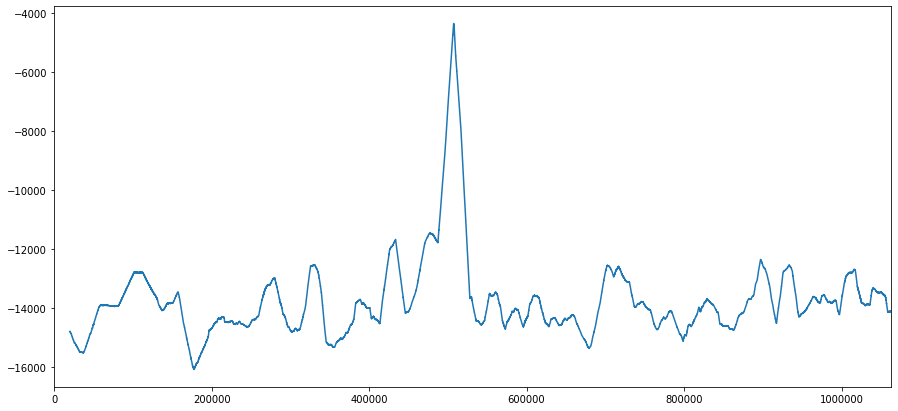

In [49]:
fig, ax = plt.subplots(figsize=(15,7))


((score['score'].rolling(20000).mean())*-1).plot(ax=ax)

**Scat plot to see the score through the noise**

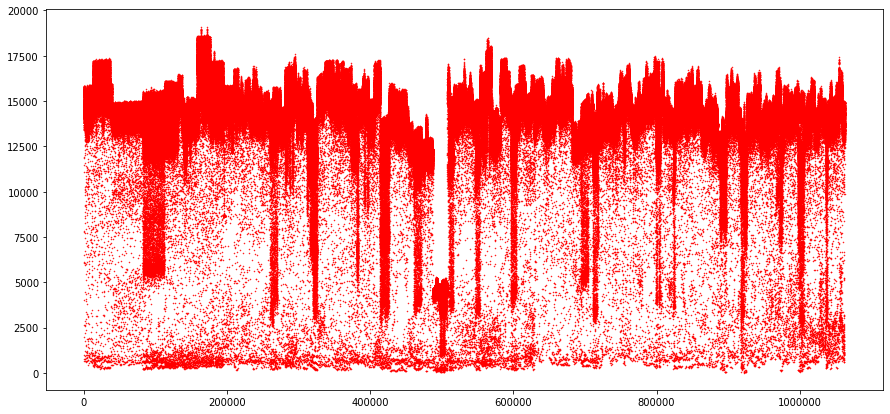

In [51]:
plt.subplots(figsize=(15,7))
plt.plot(score.index, score['score'],'r.', markersize=1)

# KMeans approach

**Kmeans approach will do the same thing as the OC-SVM**

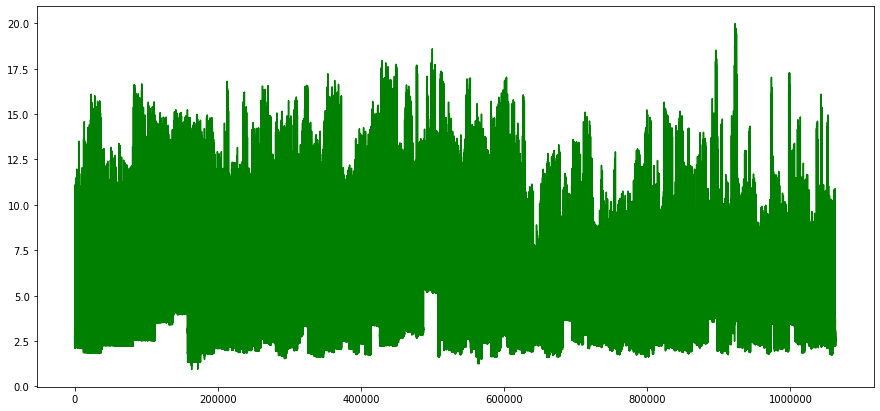

In [23]:
main_df = pd.read_csv('data.csv')
main_df = main_df.drop(['day', 'hour', 'sample', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)
X = preprocessing.scale(X)
train_percentage = 0.15
train_size = int(len(main_df.index)*train_percentage)
X_train = X[:train_size]
kmeans = KMeans(n_clusters=1)
kmeans.fit(X_train)
k_anomaly = main_df.copy()
k_anomaly = pd.DataFrame(kmeans.transform(X))

#Saving cluster distane into csv file
k_anomaly.to_csv('compiled_df//KM_Distance.csv')

#Plot
plt.subplots(figsize=(15,7))

plt.plot(k_anomaly.index, k_anomaly[0], 'g', markersize=1)

**Plotting Validation loss and Training loss over the epochs**

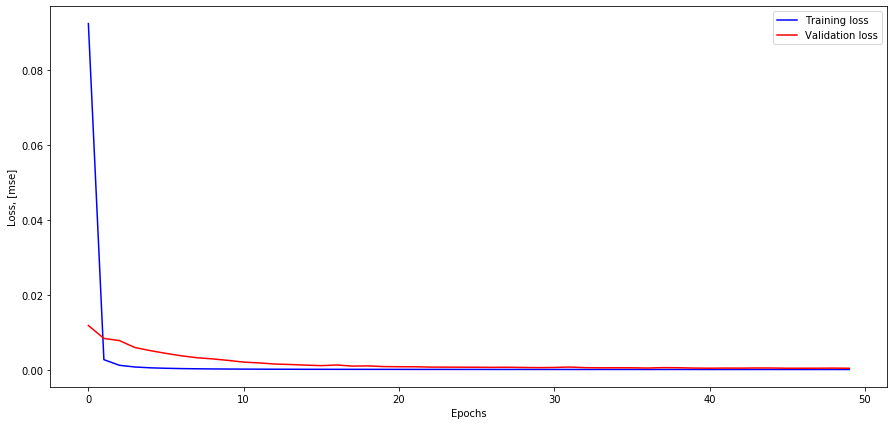

In [17]:
plt.subplots(figsize=(15,7))

plt.plot(history.history['loss'],'b',label='Training loss')
plt.plot(history.history['val_loss'],'r',label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')

plt.show()

**Now we will feed the algortihm the same training data, and make it try to reconstruct data. We will then see the distribution of the loss over the train data, further on we will use this distribution to determine some Thresholds.**

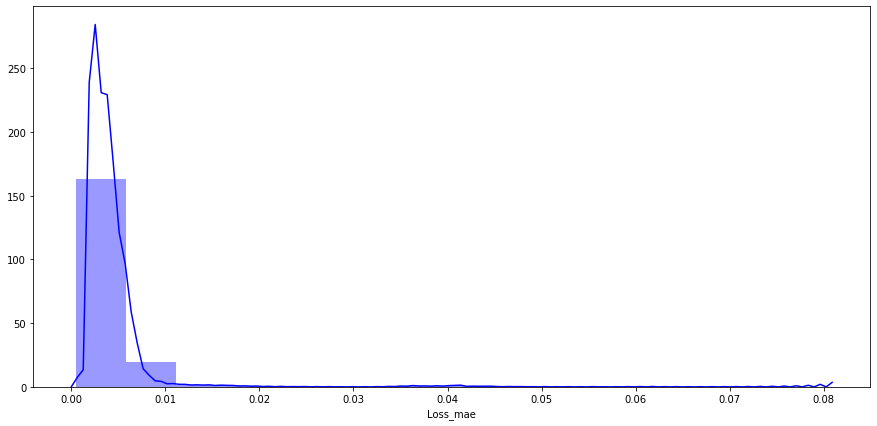

In [24]:
#Reconstructing train data
X_pred = model.predict(np.array(X_train))

#Creating dataframe for reconstructed data
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X_train).index

#Dataframe to get the difference of predicted data and real data. 
scored = pd.DataFrame(index=pd.DataFrame(X_train).index)
#Returning the mean of the loss for each column
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

#plot
plt.subplots(figsize=(15,7))
sns.distplot(scored['Loss_mae'],
             bins = 15, 
             kde= True,
            color = 'blue');

**Now to do the same thing but with all our data to see the loss over time, this will give us interesting data.**

Text(0, 0.5, 'Loss, [mse]')

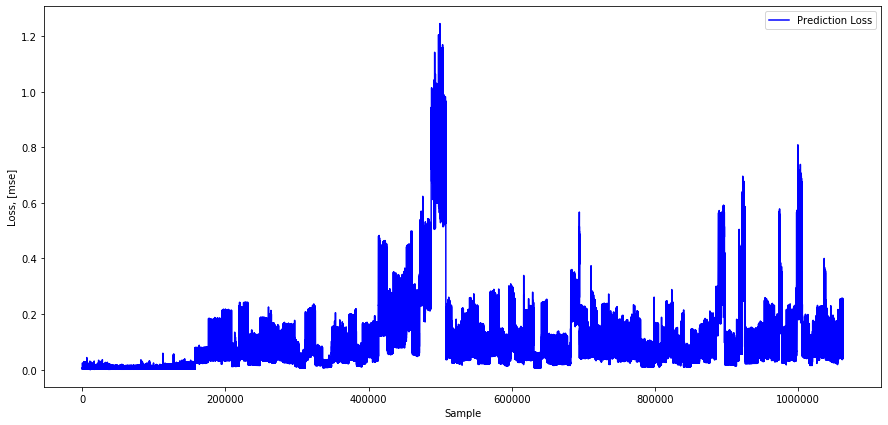

In [19]:
#Reconstructing full data
X_pred = model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(X).index

#Returning mean of the losses for each column and putting it in a dataframe
scored = pd.DataFrame(index=pd.DataFrame(X).index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X), axis = 1)

#Plot size
plt.subplots(figsize=(15,7))


#Saving dataframe
scored.to_csv('compiled_df//AutoEncoder_loss.csv')

#Plot
plt.plot(scored['Loss_mae'],'b',label='Prediction Loss')

plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Loss, [mse]')

**Plotting each algorithm scoring together, with OCSVM flipped over 0.**

**Looking for correlation between the algorithms**

**Loss Distribution over training data**

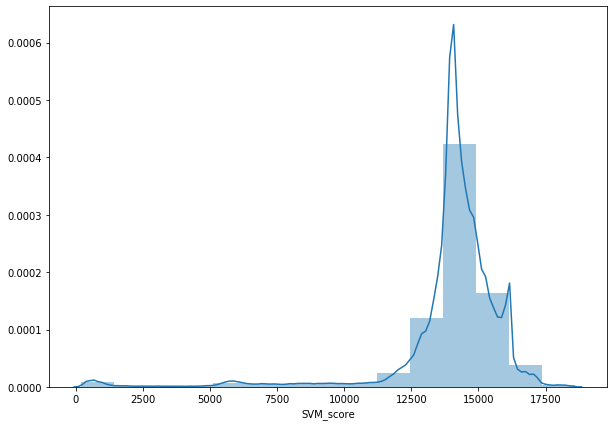

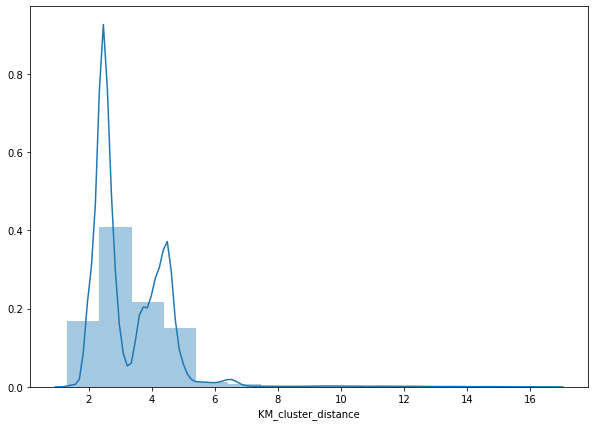

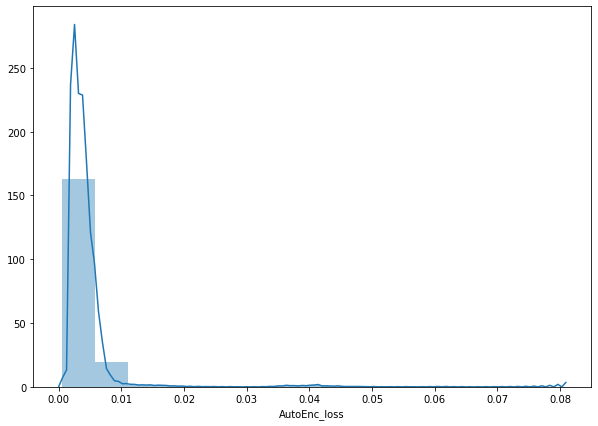

In [33]:
#Plot size
plt.subplots(figsize=(10,7))
#Hist plot of first 160.000 rows, 15 bins
sns.distplot(corr['SVM_score'].head(160000), bins=15)
#Show
plt.show()

plt.subplots(figsize=(10,7))
sns.distplot(corr['KM_cluster_distance'].head(160000),bins=15)
plt.show()


**Loss distribution over entire dataset**

**Scatter plot of the algorithm scores vs each other**

**Now we will see Loss distribution by month**

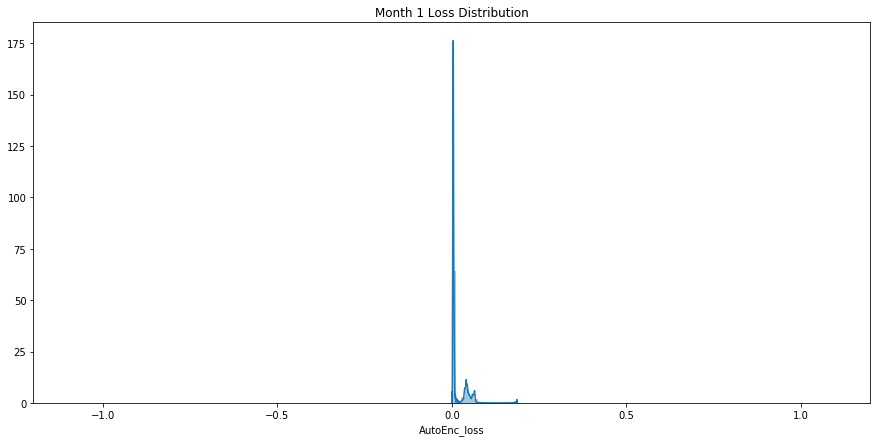

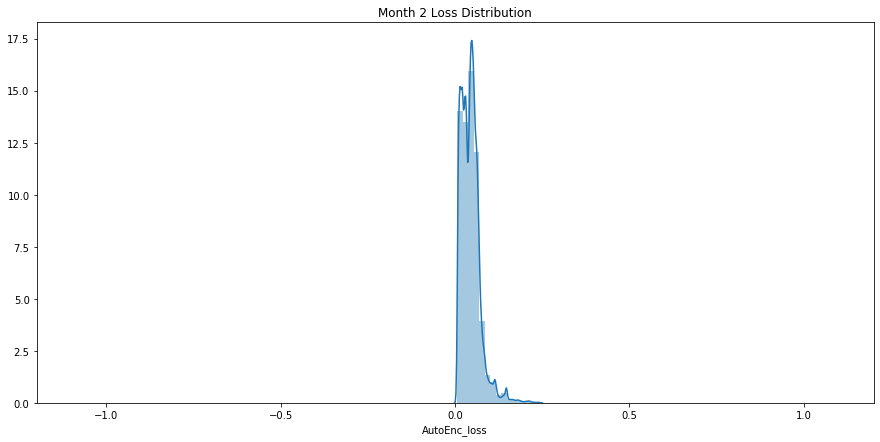

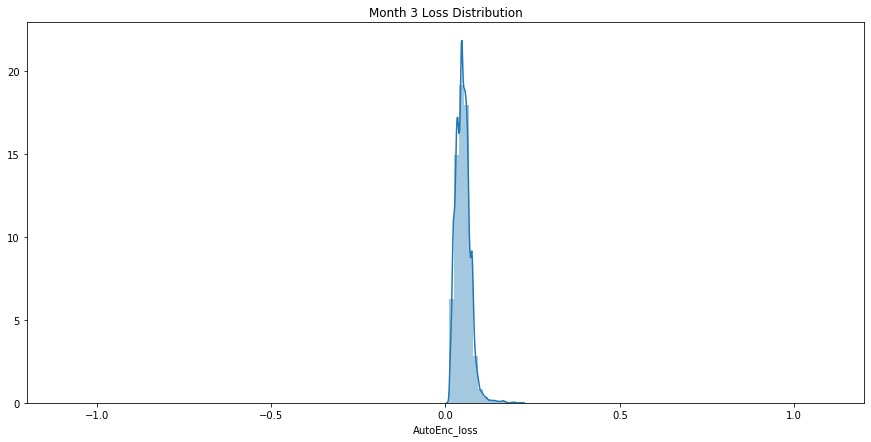

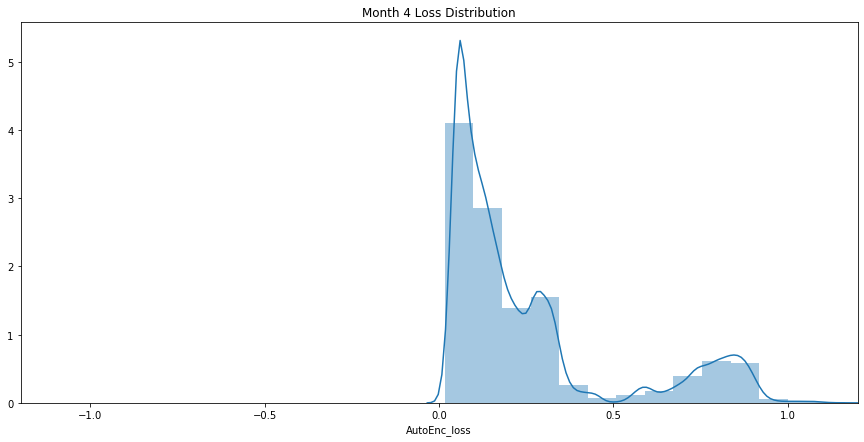

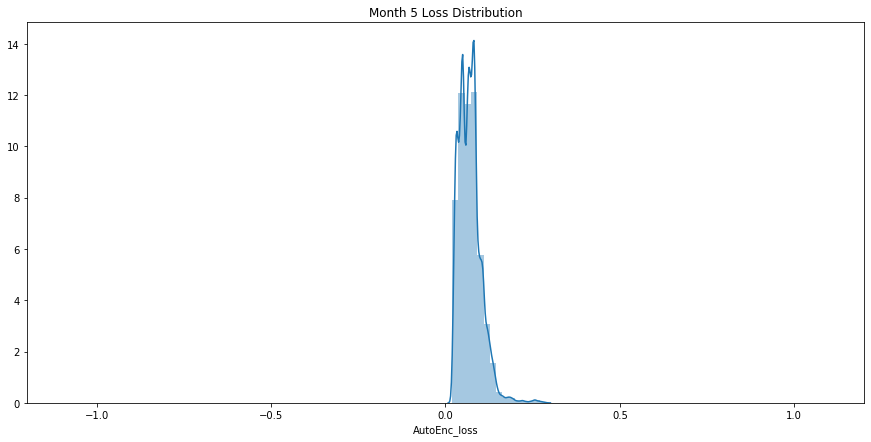

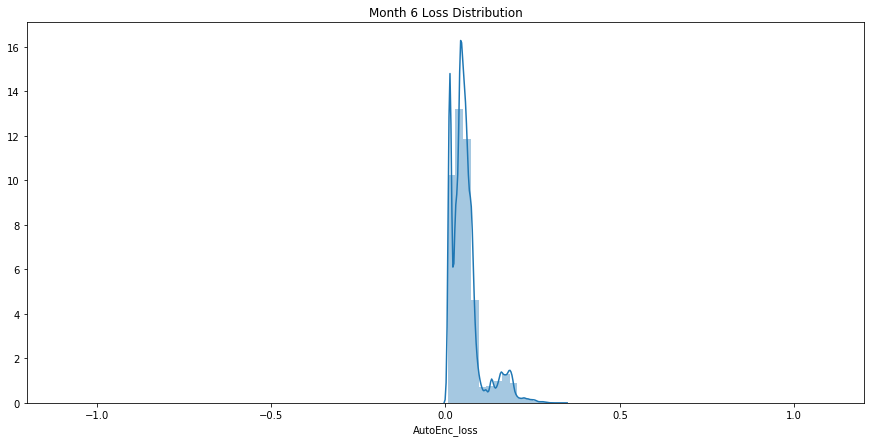

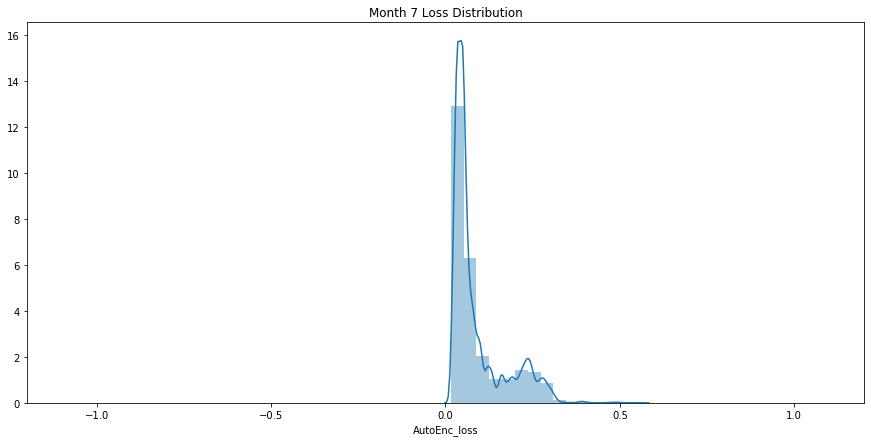

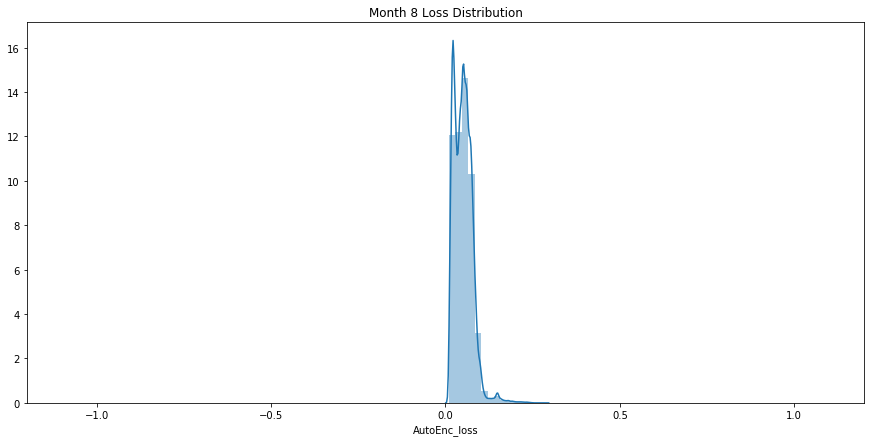

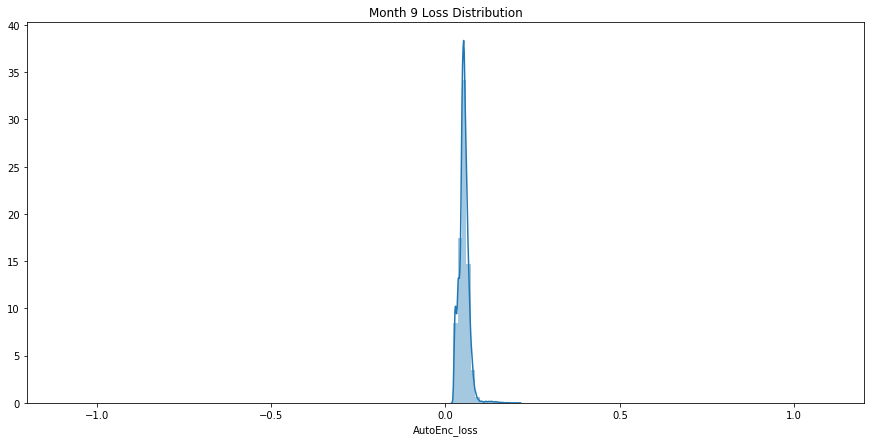

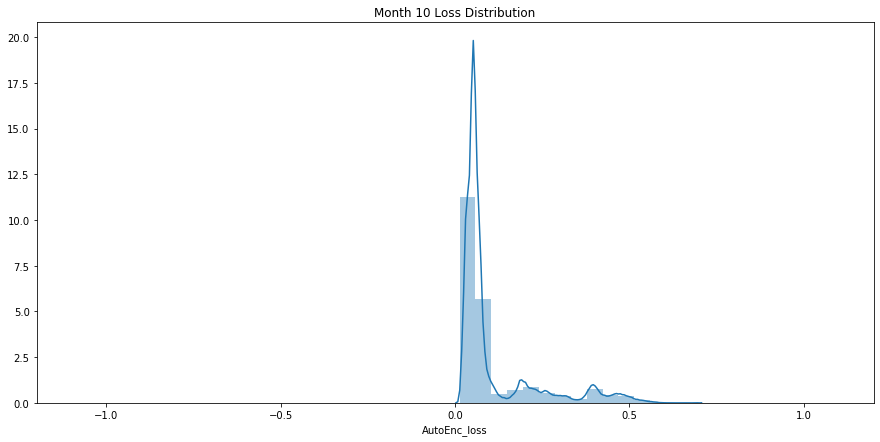

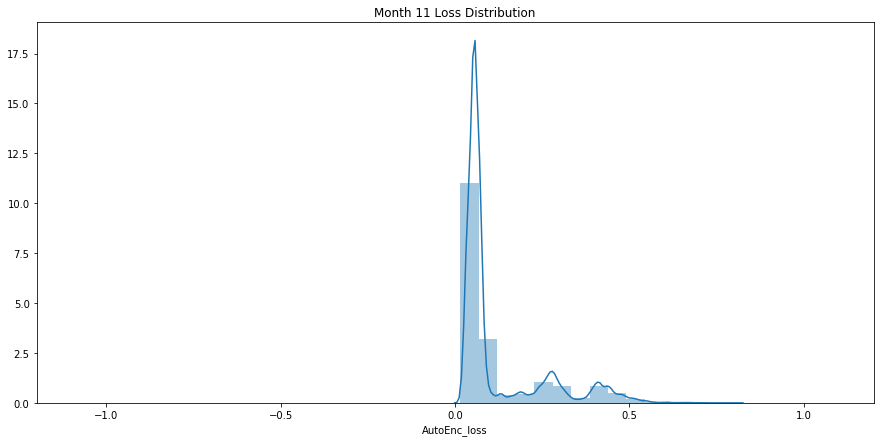

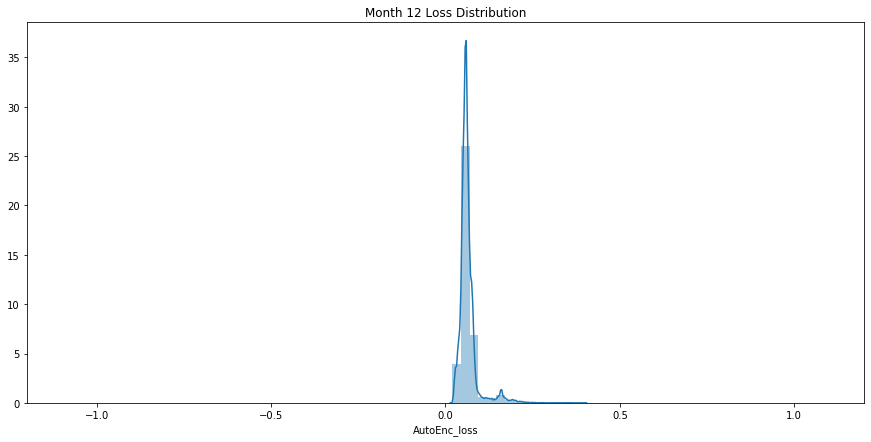

In [3]:
main_df['loss'] = corr['loss']
months = main_df['month'].dropna().unique()
for month in months:
    month_df = main_df.groupby('month').get_group(month)
    plt.subplots(figsize=(15,7))
    sns.distplot((month_df['loss']), bins=15).set_title(f'Month {month} Loss Distribution')
    #X axis limits
    plt.xlim([-1.2,1.2])
    plt.show()

    
    
    
    

In [14]:
main_df['loss'] = corr['loss']
months = main_df['month'].dropna().unique()
for month in months:
    month_df = main_df.groupby('month').get_group(month)
    kurt = (month_df['loss']).kurtosis()
    print(f'Month {month} kurtosis = {kurt}')

Month 1 kurtosis = 5.905209401266553
Month 2 kurtosis = 5.937138485503365
Month 3 kurtosis = 4.285537495036374
Month 4 kurtosis = 0.9455247699324056
Month 5 kurtosis = 4.510143336927001
Month 6 kurtosis = 3.8201513892403636
Month 7 kurtosis = 1.9795239625157577
Month 8 kurtosis = 4.817953133797834
Month 9 kurtosis = 8.583822668974324
Month 10 kurtosis = 3.000952353094135
Month 11 kurtosis = 1.842456002553691
Month 12 kurtosis = 16.948971694197393


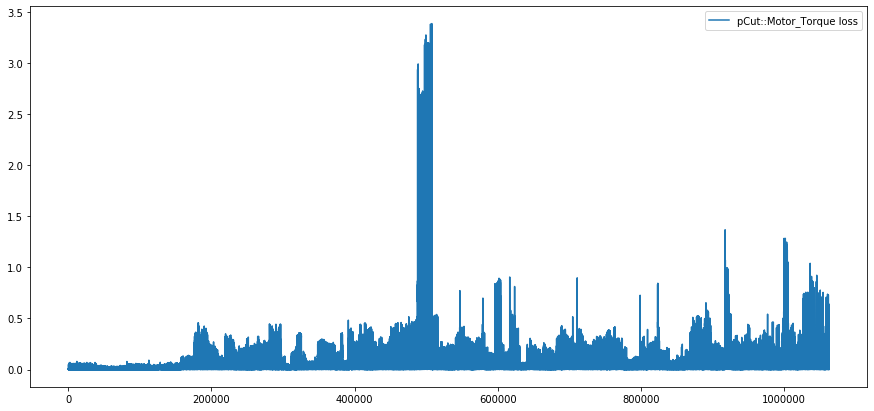

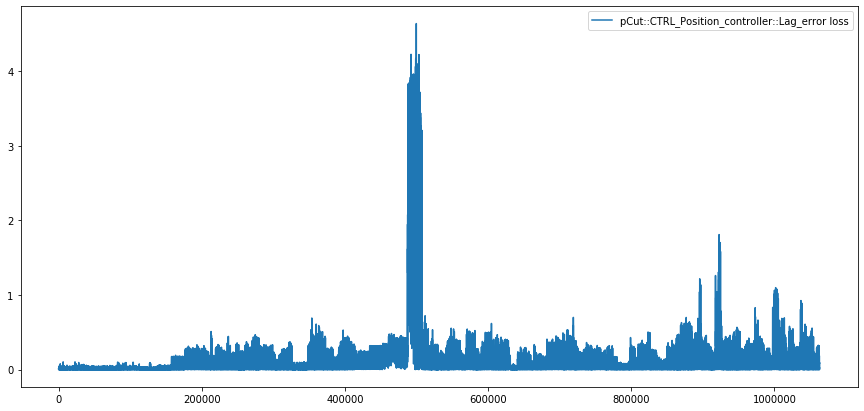

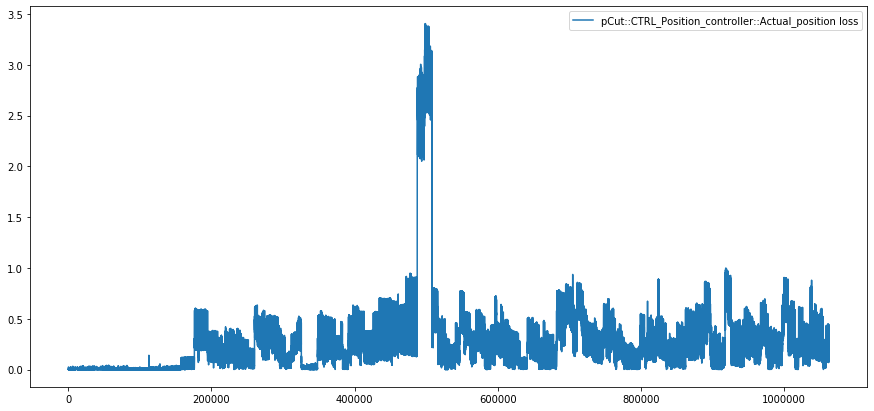

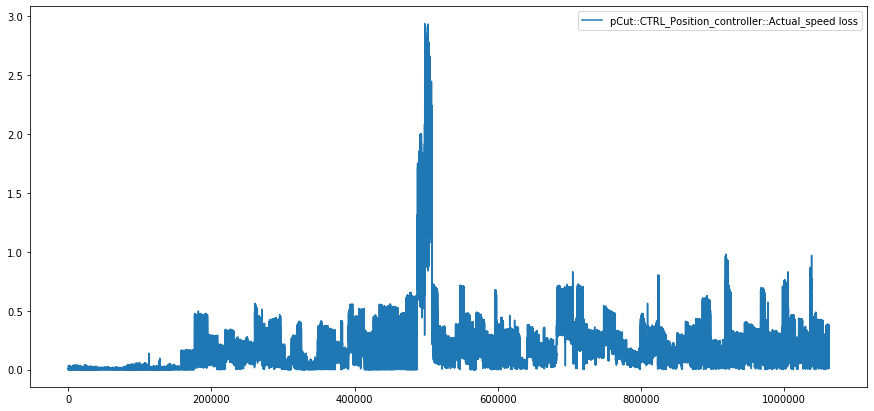

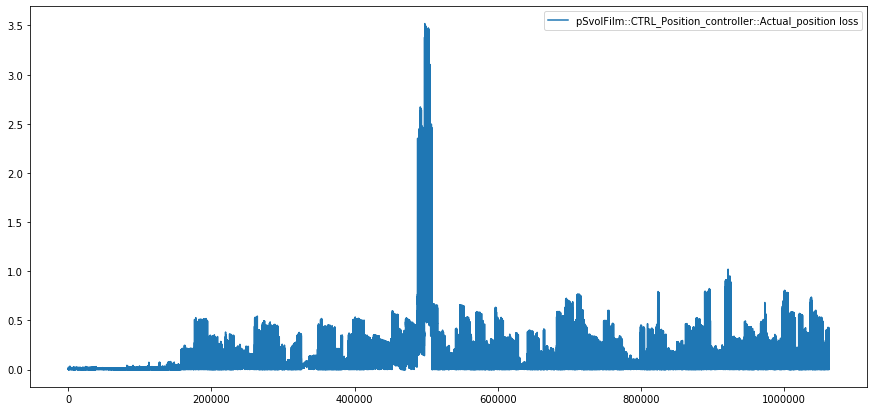

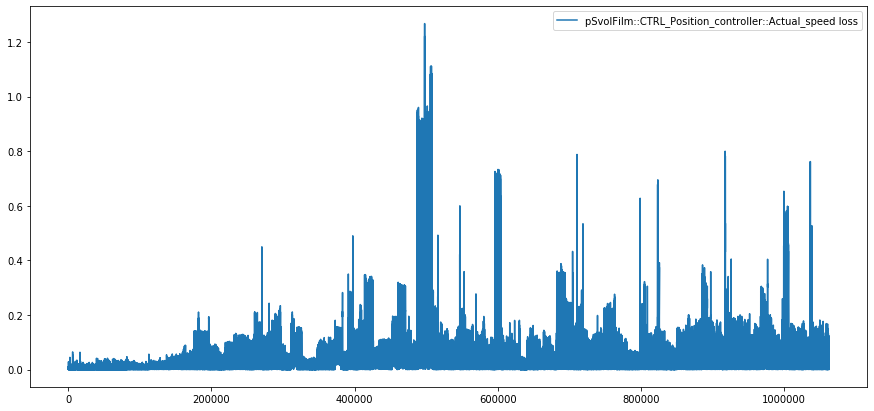

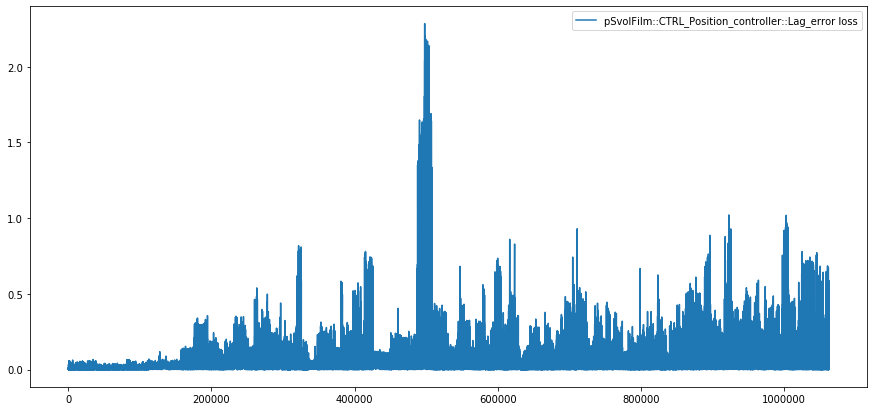

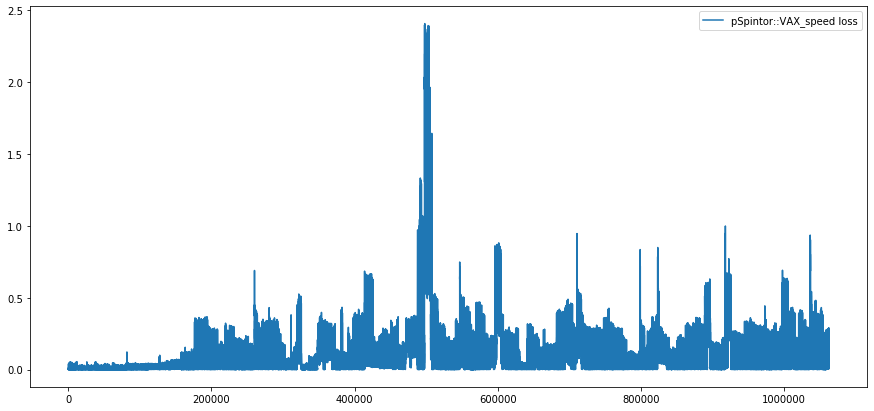

In [26]:
#Predicting and passing prediction to dataframe
X_pred = model.predict(np.array(X))
X_pred = pd.DataFrame(X_pred,columns=main_df.columns)
X_pred.index = pd.DataFrame(main_df).index

#Passing X from an array to a dataframe
X = pd.DataFrame(X,columns=main_df.columns)
X.index = pd.DataFrame(main_df).index

#Dataframe where all the loss per columns will go
loss_df = pd.DataFrame()

#Dropping mode as it can't logically contribute to degredation
main_df.drop('mode',axis=1, inplace=True)

#Iterating through columns
for column in main_df.columns:
    #Getting the loss of the prediction for that column
    loss_df[f'{column}'] = (X_pred[f'{column}'] - X[f'{column}']).abs()
     
    #Plotting the loss
    plt.subplots(figsize=(15,7))
    plt.plot(loss_df.index, loss_df[f'{column}'], label=f'{column} loss')
    plt.legend(loc='upper right')
    
    plt.show()

#Saving loss Dataframe
loss_df.to_csv('loss_p_column.csv')

**Now we will apply Softmax function to each row so we can get the percentage that each colunm contributes to the total loss. As for the sum of each row will give us 1.**

In [17]:
sftmax_df = pd.read_csv('loss_p_column.csv', index_col=0)
sftmax_df = softmax(sftmax_df, axis=1)
sftmax_df.describe()

,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
count,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06
mean,1.204693e-01,1.228772e-01,1.397278e-01,1.308415e-01,1.240942e-01,1.192652e-01,1.198906e-01,1.228342e-01
std,1.156266e-02,1.106904e-02,4.686768e-02,1.284813e-02,1.282596e-02,1.204172e-02,1.245117e-02,1.192981e-02
min,1.865649e-02,1.793434e-02,9.833109e-02,1.357752e-02,3.297161e-02,5.295062e-03,1.148547e-02,1.280443e-02
25%,1.188391e-01,1.192631e-01,1.249067e-01,1.248310e-01,1.204438e-01,1.170258e-01,1.175876e-01,1.207791e-01
50%,1.228176e-01,1.230697e-01,1.306992e-01,1.289261e-01,1.249669e-01,1.220746e-01,1.222299e-01,1.247807e-01
75%,1.249319e-01,1.253738e-01,1.383531e-01,1.359647e-01,1.288158e-01,1.249192e-01,1.249983e-01,1.264754e-01
max,4.107637e-01,5.458792e-01,6.134586e-01,3.269753e-01,3.202893e-01,1.681255e-01,2.141893e-01,2.156039e-01


**Plotting the percentage of each columns contribution to total loss**

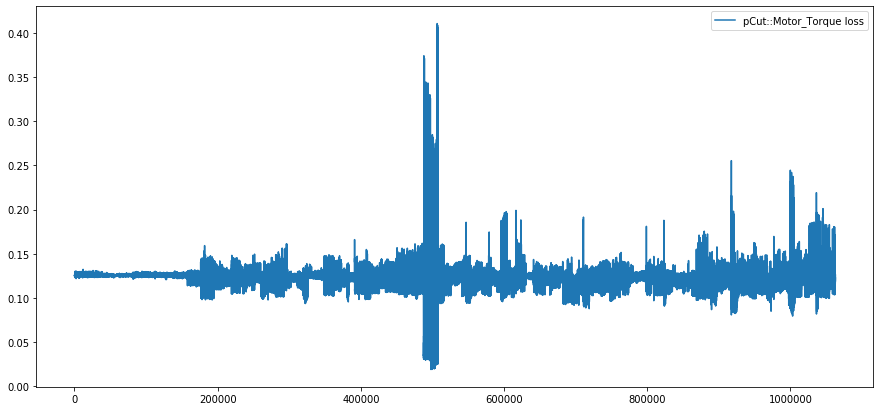

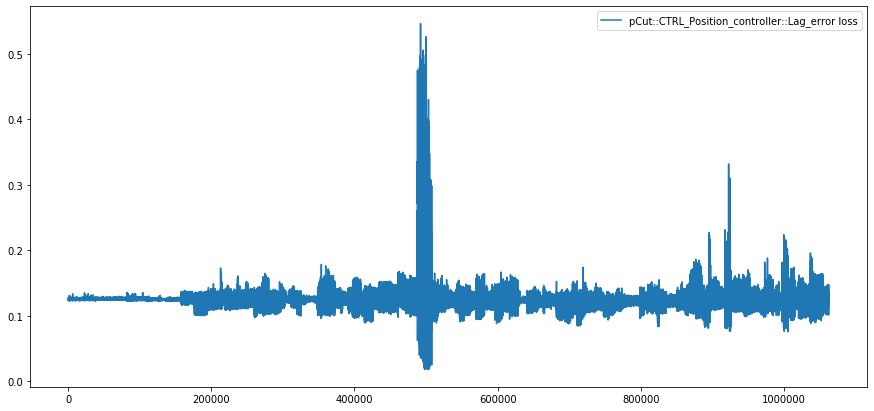

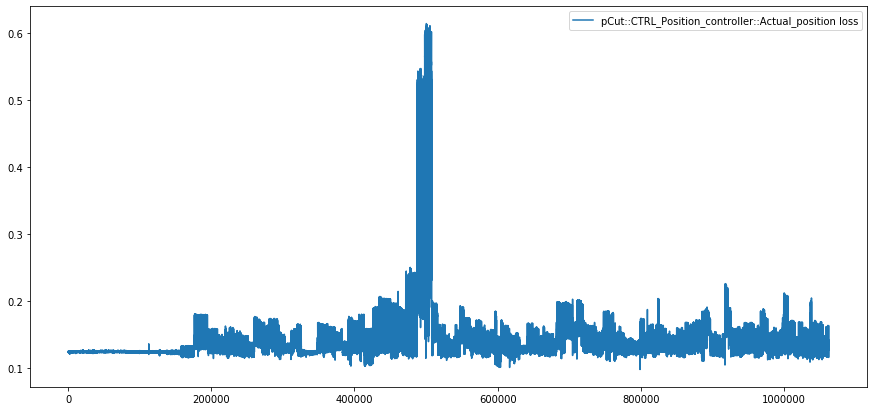

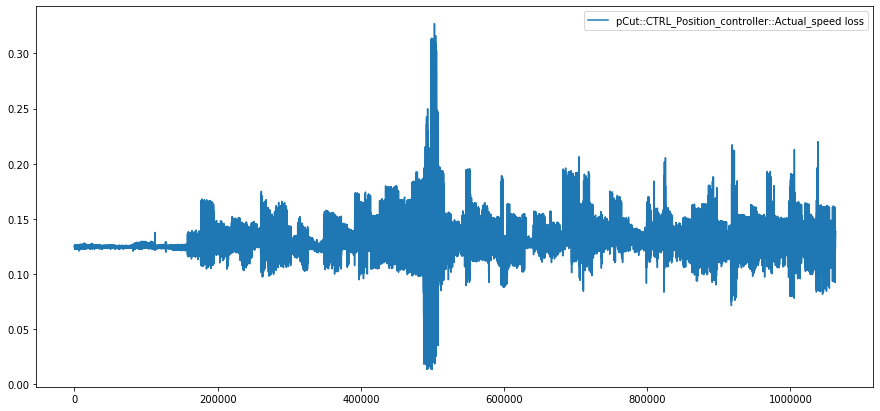

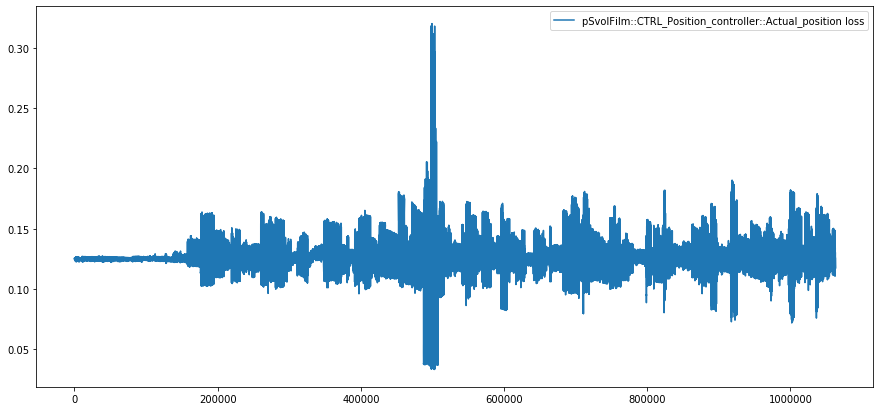

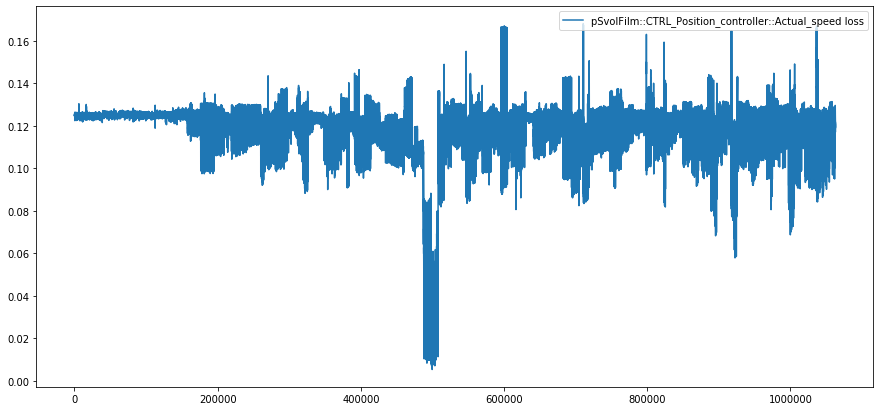

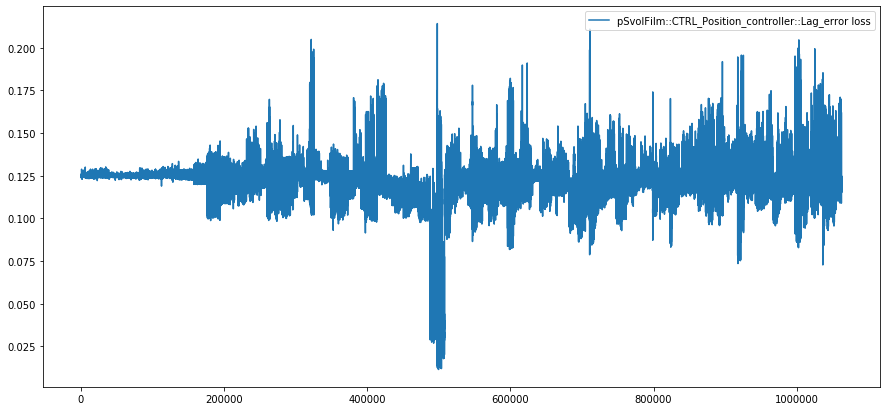

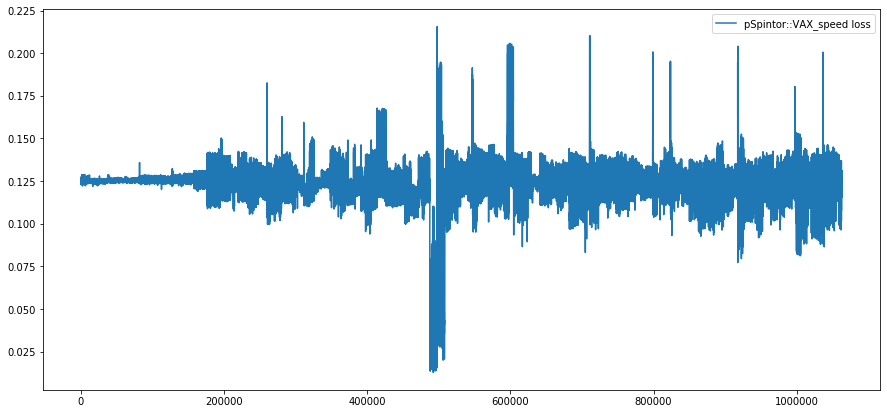

In [5]:
for column in sftmax_df.columns:
    

    plt.subplots(figsize=(15,7))
    plt.plot(sftmax_df.index, sftmax_df[f'{column}'], label=f'{column} loss')
    plt.legend(loc='upper right')
    
    plt.show()

**Now we can plot a stack plot to better visualize the contribution of each column to the total loss. As you will see the Blades position contributes very much to the total loss on that peak we saw. We will look in closer to that slice.**

(0, 1)

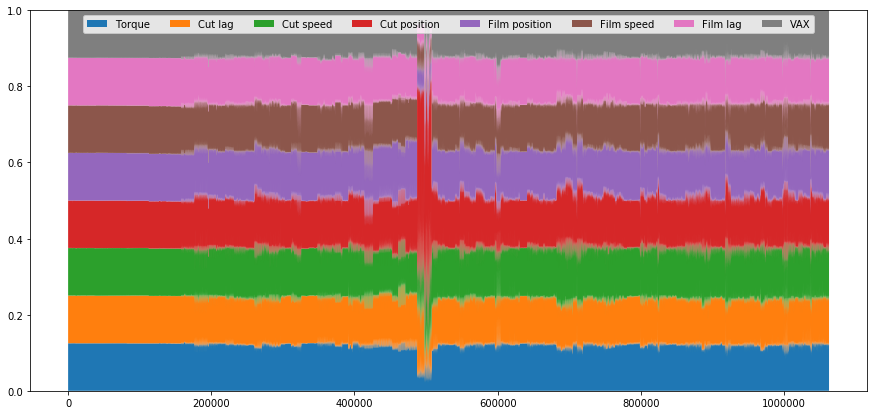

In [6]:
plt.subplots(figsize=(15,7))

#Labels for stackbar plot
df_label = ['Torque', 'Cut lag','Cut speed','Cut position','Film position','Film speed','Film lag','VAX']

#Stackbar plot
plt.stackplot(sftmax_df.index, sftmax_df['pCut::Motor_Torque'],
             sftmax_df['pCut::CTRL_Position_controller::Lag_error'],
             sftmax_df['pCut::CTRL_Position_controller::Actual_speed'],
              sftmax_df['pCut::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_speed'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Lag_error'],
             sftmax_df['pSpintor::VAX_speed'],
             labels = df_label)

plt.legend(loc='upper center', ncol=8)

plt.ylim(0,1)

(0, 1)

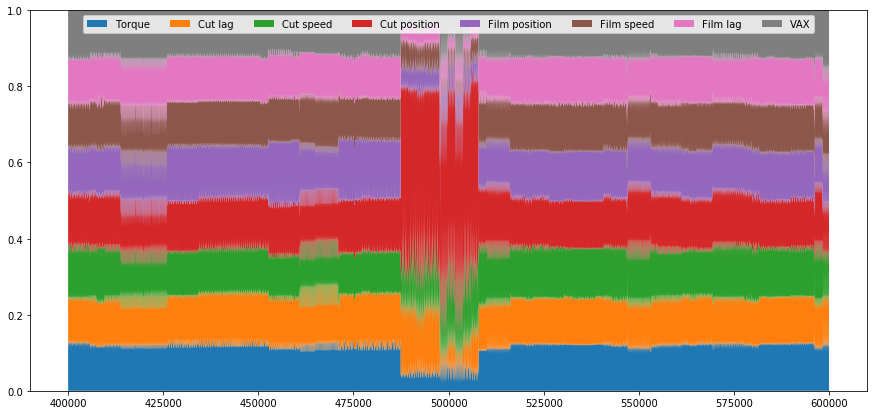

In [8]:
plt.subplots(figsize=(15,7))

df_label = ['Torque', 'Cut lag','Cut speed','Cut position','Film position','Film speed','Film lag','VAX']

#Grabbing the slice where the larger anomaly is
sftmax_df = sftmax_df[400000:600000]

plt.stackplot(sftmax_df.index, sftmax_df['pCut::Motor_Torque'],
             sftmax_df['pCut::CTRL_Position_controller::Lag_error'],
             sftmax_df['pCut::CTRL_Position_controller::Actual_speed'],
              sftmax_df['pCut::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_position'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Actual_speed'],
             sftmax_df['pSvolFilm::CTRL_Position_controller::Lag_error'],
             sftmax_df['pSpintor::VAX_speed'],
             labels = df_label)

plt.legend(loc='upper center', ncol=8)

plt.ylim(0,1)

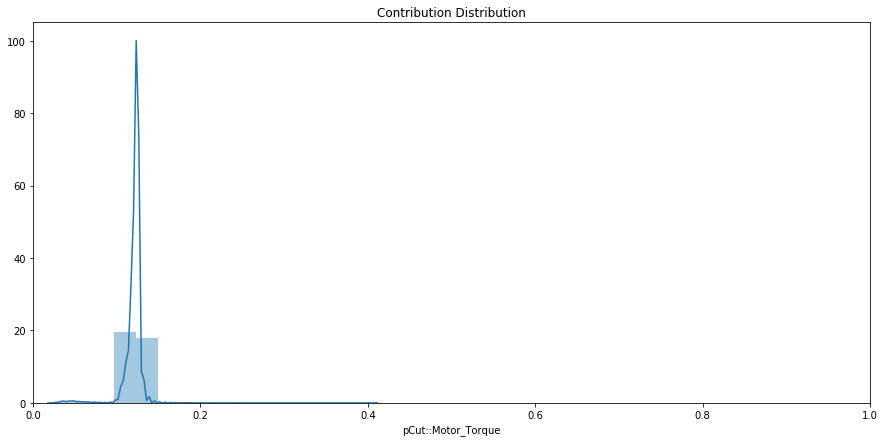

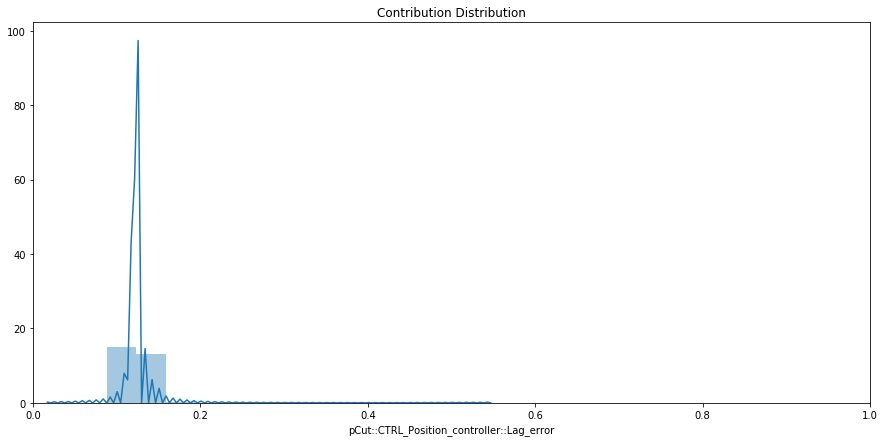

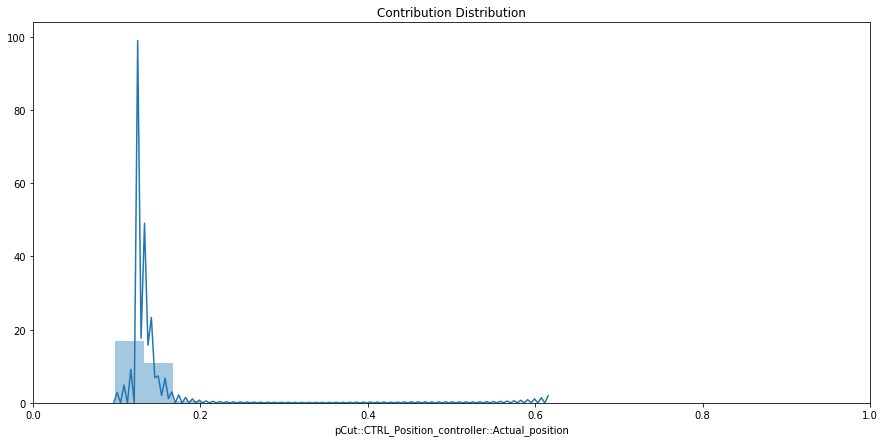

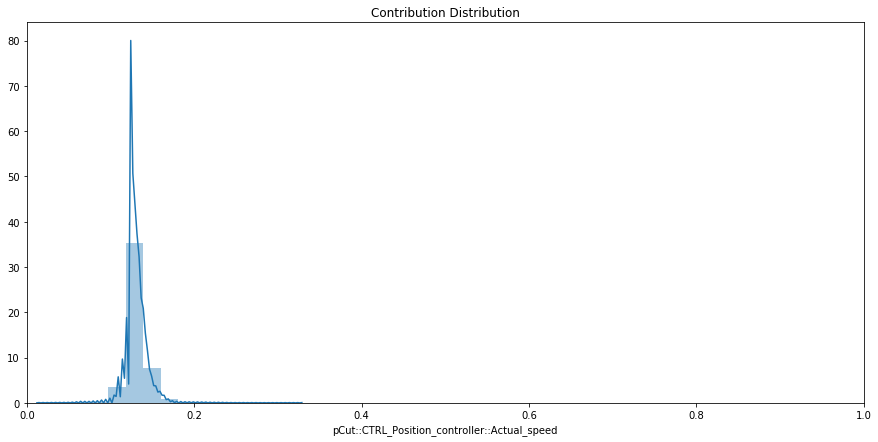

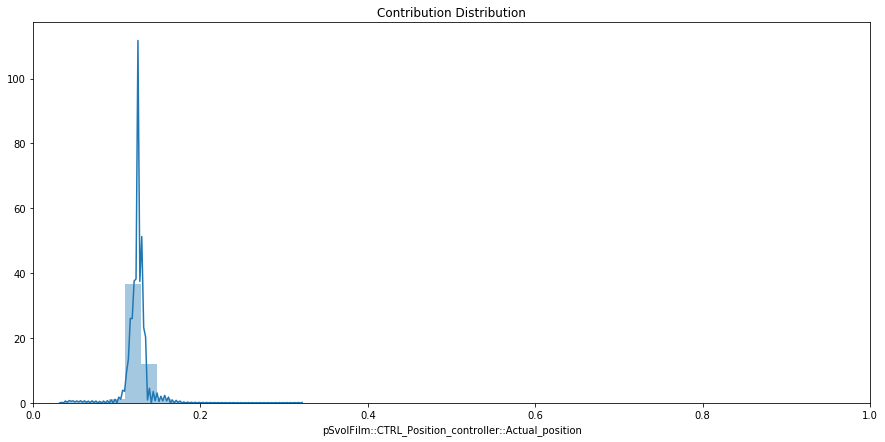

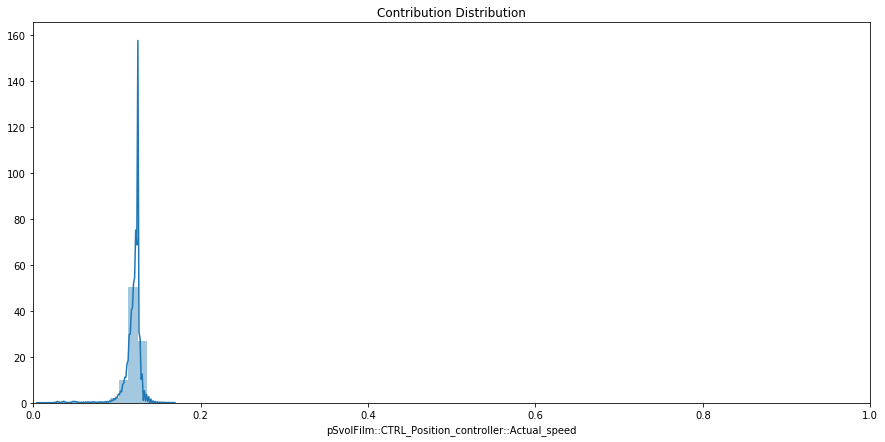

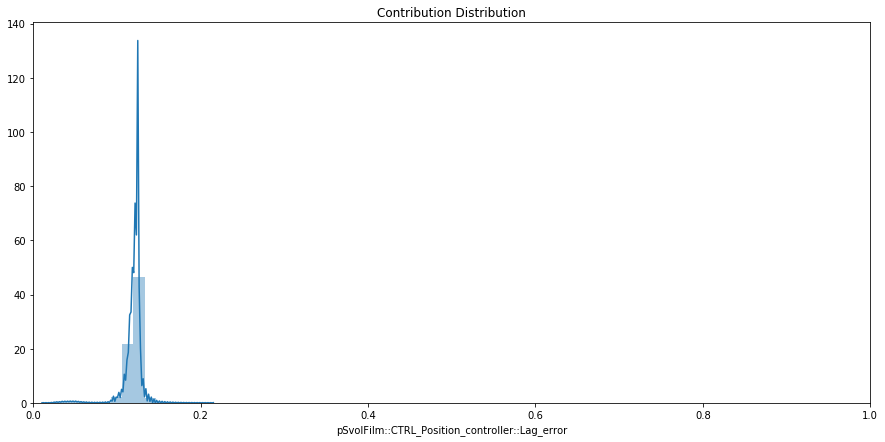

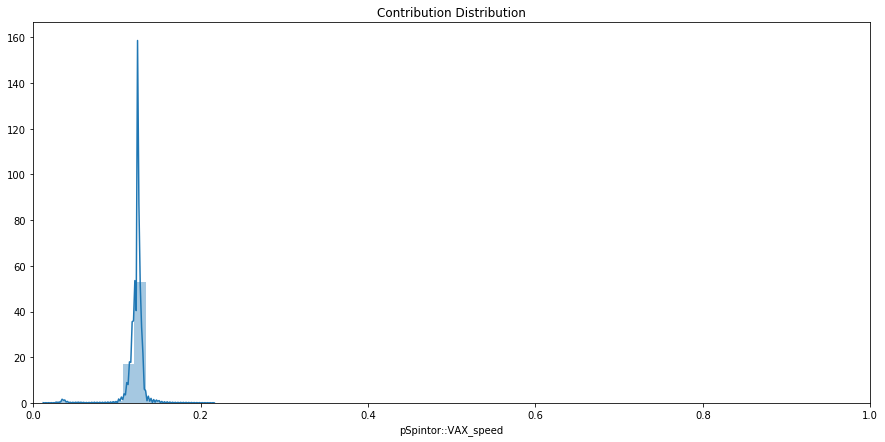

In [22]:
for column in sftmax_df.columns:
    

    plt.subplots(figsize=(15,7))
    
    sns.distplot(( sftmax_df[f'{column}']), bins=15).set_title(f'Contribution Distribution')
    plt.xlim(0,1)
    
    plt.show()